In [149]:
%run conjoint_triad_method.ipynb
%run modeling.ipynb
%run autocovariance.ipynb

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D

%matplotlib inline

In [162]:
# Constants used to reshape inputs for neural network
autocovariance_input_shape = (217,2)
conjoint_triad_input_shape = (343,2)

## Modeling Protein-Protein Interactions

This will be our main notebook for calling helper preprocessing functions, calling helper modeling functions, and evaluating our model. It is organized into three parts: conjoint triad modeling, autocovariance modeling, and model selection/evaluation.

### Part One: Modeling with the Conjoint Triad Method
Please refer to conjoint_triad_method.ipynb for details on the conjoint triad method for encoding amino acid sequences.

In [30]:
# Load in cleaned data
df = pd.read_csv("../data/train_cleaned.csv")

In [31]:
# preprocess sequences with conjoint triad method
df = conjoint_triad_preprocess(df)

In [161]:
# function to reshape feature vector for neural network input
# Side Note: the fact that this function took the longest
#            to write out of any other function in the
#            project speaks to the difficulties of prepping
#            features for deep learning.

def prepare_train_test_split(features, target, shape):
    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
    
    X_train = np.stack(X_train)
    X_test = np.stack(X_test)

    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    X_train = X_train.reshape(X_train.shape[0], shape[0], shape[1])
    X_test = X_test.reshape(X_test.shape[0], shape[0], shape[1])
    
    return X_train, X_test, y_train, y_test

In [60]:
# Create X_train, X_test, y_train, and y_test for conjoint triad method
features = "seq_vec"
target = "interacts"

X_train_cjt, X_test_cjt, y_train_cjt_cjt, y_test = prepare_train_test_split(features, target, conjoint_triad_input_shape)

In [76]:
# Please refer to helper_classes for this object used to keep
# track of grid searches
gs = GridSearchContainer()

In [77]:
# Set the data for the grid search container
gs.set_data(X_train_cjt, X_test_cjt, y_train_cjt, y_test_cjt)

In [150]:
# Search Convolutional Neural Network params for best model
# See modeling.ipynb for the list of searched params
# and details about how the gridsearch is constructed
gs.search(cjt_cnn_model, cjt_cnn_params, mod_name="cnn_conjoint_triad")

Train accuracy: 0.7844932915973329
Test accuracy: 0.7381135237031348


In [147]:
# Search Feed Forward Neural networks for best performance
gs.search(cjt_ff_model, cjt_ff_params, mod_name="ff_conjoint_triad")

Train accuracy: 0.871743253778931
Test accuracy: 0.7659009983941911


### Part Two: Modeling with Autocovariance
Please refer to autocovariance.ipynb for details on how autocovariance is applied to amino acid sequence data.

In [151]:
# Load in cleaned dataset
df = pd.read_csv("../data/train_cleaned.csv")
# Apply autocovariance preprocessing
df = apply_autocovariance(df)

/Users/nlonberg/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:436: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [156]:
# create data objects
features = "autocovariances"
target = "interacts"

X_train_ac, X_test_ac, y_train_ac, y_test_ac = prepare_train_test_split(features,
                                                                        target,
                                                                        autocovariance_input_shape)

In [157]:
# Reset gridsearch container data
gs.set_data(X_train_ac, X_test_ac, y_train_ac, y_test_ac)

In [158]:
# Search over cnn and feedforward params for best models
gs.search(autocov_cnn_model, autocov_cnn_params, mod_name="cnn_autocovariance")
gs.search(autocov_ff_model, autocov_ff_params, mod_name="ff_autocovariance")

Train accuracy: 0.5774229959156126
Test accuracy: 0.5594498359282273
Train accuracy: 0.6242363591933626
Test accuracy: 0.6027717656915451


### Part Three: Model Selection and Evaluation
Based on our grid searches, we will choose the model with the best accuracy and evaluate it.

In [159]:
# Review gridsearches.
gs.model_df.head()

,batch_size,conv_layers,dropout,epochs,hidden_layers,hidden_nodes,input_shape,accuracy
cnn_conjoint_triad_0,512,1.0,0.0,20,1,100,"(343, 2)",0.764898
ff_conjoint_triad_1,512,NaN,0.0,20,1,100,"(343, 2)",0.742940
cnn_conjoint_triad_2,512,1.0,0.0,20,1,100,"(343, 2)",0.741554
cnn_autocovariance_3,512,1.0,0.0,10,1,100,"(217, 2)",0.632871
ff_autocovariance_4,512,NaN,0.0,10,1,100,"(217, 2)",0.585464


It looks like our first entry, "cnn_conjoint_triad_0" had the best accuracy. Let's evaluate it.

In [160]:
# This member variable has a list of tuples describing each model (model, accuracy)
gs.best_models

[(<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier at 0x7fa7403d14d0>,
  0.7648976706135995),
 (<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier at 0x7fa740ed2890>,
  0.7429396476131984),
 (<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier at 0x7fa9b9a9e7d0>,
  0.741554377703927),
 (<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier at 0x7fa8606e7910>,
  0.6328706728688095),
 (<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier at 0x7fa948a4b550>,
  0.5854635566422435)]

In [84]:
# Get the best model
cnn_best = gs.best_models[0][0]

In [89]:
# Get predicitions on the testing set
y_pred = cnn_best.predict(X_test_cjt)

-----------------False------------------
(0,0) True Negative - 7855
(0,1) False Positive - 4297
------------------True------------------
(1,0) False Negative - 3166
(1,1) True Positive - 13328

Accuracy: 73.9475% - (1) Correct Predictions / ALL predictions
---------------------------------------------------------------------------------------
Specificity: 64.6396% - (0) Correctly Predicted NO INTERACTIONS / ALL NO INTERACTIONS protein pairs
---------------------------------------------------------------------------------------
Sensitivity: 80.8051% - (1) Correctly Predicted INTERACTIONS / ALL INTERACTIONS protein pairs
---------------------------------------------------------------------------------------
Precision: 75.6199% - (1) Correctly Predicted INTERACTIONS / Predicted INTERACTIONS protein pairs
---------------------------------------------------------------------------------------


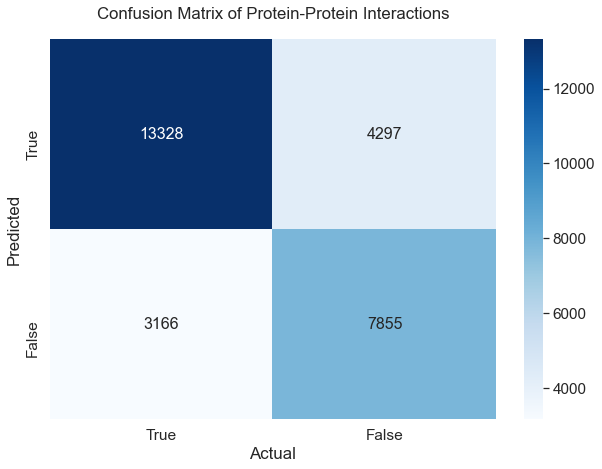

In [121]:
# This code is adapted from code written by Tony Lucci

tn, fp, fn, tp = confusion_matrix(y_test_cjt, y_pred).ravel()

# Plot
array = [[tp, fp],
         [fn, tn]
        ]

df_cm = pd.DataFrame(array, [True, False], [True, False])
plt.figure(figsize=(10,7))
ax = plt.axes()
sns.set(font_scale=1.4)
heatmap = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt="g")
ax.set_title("Confusion Matrix of Protein-Protein Interactions",pad=20)
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
fig = heatmap.get_figure()
fig.savefig("../heatmap.png")


# For easy consumption
print('False'.center(40, "-"))
print(f'(0,0) True Negative - {tn}')
print(f'(0,1) False Positive - {fp}')
print('True'.center(40, "-"))
print(f'(1,0) False Negative - {fn}')
print(f'(1,1) True Positive - {tp}')
print()

# Model Prediction
accu = (tn + tp) / (tn + tp + fn + fp)
print(f'Accuracy: {round(accu * 100, 4)}% - (1) Correct Predictions / ALL predictions')
print('---------------------------------------------------------------------------------------')

# Calculate the specificity
spec = tn / (tn + fp)
print(f'Specificity: {round(spec * 100, 4)}% - (0) Correctly Predicted NO INTERACTIONS / ALL NO INTERACTIONS protein pairs')
print('---------------------------------------------------------------------------------------')

# Sensitivity
sens = tp / (tp + fn)
print(F'Sensitivity: {round(sens * 100, 4)}% - (1) Correctly Predicted INTERACTIONS / ALL INTERACTIONS protein pairs')
print('---------------------------------------------------------------------------------------')

# Precision
prec = tp / (tp + fp)
print(f'Precision: {round(prec * 100, 4)}% - (1) Correctly Predicted INTERACTIONS / Predicted INTERACTIONS protein pairs')
print('---------------------------------------------------------------------------------------')

In [167]:
# Get Baseline Accuracy
df["interacts"].value_counts(normalize=True)

1    0.57368
0    0.42632
Name: interacts, dtype: float64

#### Model Selection

Our baseline accuracy is 57% and our final model's accuracy is 76% (5-fold cross validation): an improvement of 19%. We selected the CNN model on conjoint triad preprocessed features over other models because it had the best cross validation score and because it had good variance.  With our train/test split, the model scored 78% on training set and 73% on the testing set. The feed forward model for cjt scored 87% on the training set and 76% testing set, but had 74% accuracy on the grid search cross validation. This level of variance is undesirable, which is why we went with the CNN model, despite its lower scores.  The autocovariance models had much lower accuracy scores, ranging in the 60s.

#### Model Evaluation

There is no specific stated intent as far as minimizing false positives or false negatives.  Binary classification is a flawed interpretation of the problem of protein-protein interactions anyway.  Proteins have attraction to each other on a continuous scale.  Many proteins interact with each other but don't bind or perform a meaningful function.  Those proteins are chemically attracted but still categorized as "not interacting".  The model has 81% sensitivity but 65% specificity.  This means the model overpredicts interaction.  To be fair to the model, it may be detecting the ingredients for chemical attraction but the protein pair don't formally bind or interact in a known way.  An extension of this project might look at building a regressor to predict the association constant between two proteins.